---
title: "FWL에 기반한 잔차화 방법론 구현 노트북"
date: 2025-07-10
category: "Causal Inference"
tags: ["residualization", "FWL"]
excerpt: "잔차화를 하기 위해 nusiance function을 만들고 결과를 분석하는 노트북"
---

# Load Data

In [ ]:
# from src.dataloader.vault.main import VaultDatasetLoader
# from src.dataloader.vault.utils import split_df_od_os
# from src.utils.db import SOFTCRM_DBINFO, get_conn

# import warnings
# import pandas as pd
# import numpy as np

# warnings.filterwarnings("ignore")

# # pandas display 옵션 설정 - 모든 열 보이기
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

# loader = VaultDatasetLoader()
# feature_df, y_df = loader.run(start_date="2022-01-01", end_date="2024-12-31", piol_data_path="./data/PIOL렌즈주문서.xlsx", refresh=False, db="crm_emr")


# # y_df의 oper_date와 feature_df의 date를 기준으로 병합
# merged_df = pd.merge(y_df, feature_df,
#                     left_on=['cust_num', 'oper_date'],
#                     right_on=['cust_num', 'date'],
#                     how='left')

# merged_df = split_df_od_os(merged_df)

# query = """SELECT CUST_NUM, BIRTH_DAY FROM VIEW_CUSTOM_JUMIN"""
# with get_conn(SOFTCRM_DBINFO) as conn, conn.cursor() as cursor:
#     cursor.execute(query)
#     result = cursor.fetchall()

# age_df = pd.DataFrame([list(res) for res in result], columns=["cust_num", "birthday"])
# age_df = age_df.applymap(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)
# age_df["birthday"] = pd.to_datetime(age_df["birthday"], errors="coerce", format="%Y-%m-%d")
# age_df = age_df.dropna().reset_index(drop=True)
# age_df["cust_num"] = age_df["cust_num"].apply(lambda x: x.strip())
# cust_age_dict = dict(zip(age_df["cust_num"], age_df["birthday"]))

# merged_df['birthday'] = merged_df['cust_num'].map(cust_age_dict)
# merged_df['age'] = merged_df.apply(lambda row: pd.to_datetime(row['oper_date']).year - row['birthday'].year if pd.notnull(row['birthday']) else np.nan, axis=1)

In [ ]:
# merged_df.to_csv("./merged_df_2022_01_01_2024_12_31_with_age.csv", index=False)

# Modules

In [23]:
from src.preprocessing.constants import ALL_RANGES_NO_SIDE
import pandas as pd
import numpy as np


def load_data() -> tuple[pd.DataFrame, list, list, list]:
    """
    데이터를 로드하고 전처리하여 분석에 필요한 형태로 반환합니다.

    Returns:
        tuple[pd.DataFrame, list, list, list]:
            - df_clean (pd.DataFrame): 전처리된 데이터프레임
            - features (list): 특성 변수명 리스트 ["Cas_ata", "Cas_acd_endo", "Cas_clr", "age"]
            - treatment (list): 처치 변수명 리스트 ["size"]
            - y (list): 결과 변수명 리스트 ["meas_vault"]

    Note:
        - NaN 값이 있는 행은 제거됩니다
        - size가 [12.1, 12.6, 13.2]가 아닌 경우는 제거됩니다
    """

    df = pd.read_csv("./data/merged_df_2022_01_01_2024_12_31_with_age.csv")

    df.head()
    features = ["Cas_ata", "Cas_acd_endo", "Cas_clr", "age"]
    treatment = ["size"]
    y = ["meas_vault"]

    # df 중 features, treatment, y 컬럼만 남기고 칼럼 제거, 이 칼럼들에 대한 값이 NaN인 것도 제거
    selected_columns = features + treatment + y
    df_clean = df[selected_columns].copy()

    # df['size']가 [12.1, 12.6, 13.2] 이 아닌 경우 제거
    df_clean = df_clean[df_clean["size"].isin([12.1, 12.6, 13.2])].reset_index(drop=True)

    # 이상치 제거 로직
    # 모든 컬럼에 대해 범위 적용
    for column, range_obj in ALL_RANGES_NO_SIDE.items():
        if column in df_clean.columns:
            # 컬럼 값이 범위를 벗어나면 np.nan으로 변경
            df_clean[column] = df_clean[column].where((df_clean[column] >= range_obj.min) & (df_clean[column] <= range_obj.max), np.nan)

    # Cas_cct로 vault 범위 만들고, 넘어가면 없애주기
    max_vault = ALL_RANGES_NO_SIDE["Cas_cct"].max * 1.5
    df_clean = df_clean[df_clean["meas_vault"] <= max_vault].reset_index(drop=True)

    # NaN 값이 있는 행 제거
    df_clean = df_clean.dropna()

    # 나이가 60이상 제거
    df_clean = df_clean[df_clean["age"] < 60].reset_index(drop=True)

    df_clean[y] = df_clean[y].abs()

    return df_clean, features, treatment, y

# 잔차화 진행하기

> R-learner는 FWL theorem에 이론적 배경을 두고 있습니다.   

**FWL 정리**는 다중 회귀분석에서 특정 변수의 계수를 구하는 두 가지 방법이 동일한 결과를 준다는 것을 보여줍니다:

1. **직접 회귀**: 모든 변수를 포함한 전체 회귀모형
2. **잔차화 후 회귀**: 관심 변수와 종속변수를 다른 변수들에 대해 각각 회귀하여 잔차를 구한 후, 이 잔차들 간의 회귀

수학적 표현:   

모형: `Y = Xβ + Zγ + ε`에서 β를 구하고 싶다면:

1. **방법 1**: 전체 회귀
```
β̂ = (X'M_Z X)^(-1) X'M_Z Y
```

2. **방법 2**: 잔차화
```
1. X̃ = M_Z X  (X를 Z에 회귀한 잔차)
2. Ỹ = M_Z Y  (Y를 Z에 회귀한 잔차)  
3. β̂ = (X̃'X̃)^(-1) X̃'Ỹ
```

여기서 `M_Z = I - Z(Z'Z)^(-1)Z'`는 Z에 수직인 투영행렬입니다.

잔차화가 가능해지는 이유:   

1. **직교성**: 잔차화는 다른 변수들의 영향을 제거하여 순수한 효과만 분리
2. **차원 축소**: 복잡한 다변량 문제를 단순한 이변량 문제로 변환
3. **해석 용이성**: 다른 변수들을 통제한 후의 순수한 관계 파악

> R-learner는 다음과 같은 두 단계로 구현됩니다:

1. **Propensity Score**: Treatment를 Features로 예측
2. **Outcome Function**: Outcome을 Features로 예측

**Step 1: Propensity Score (Treatment 잔차화)**:
```python
# X → T 회귀 (Treatment를 Features로 예측)
model = LogisticRegression()
model.fit(X_train, y_train)
propensity_scores = model.predict_proba(X_val)
```

**Step 2: Outcome Function (Y 잔차화)**:
```python
# X → Y 회귀 (Outcome을 Features로 예측)
# Y_residual = Y - E[Y|X]
# T_residual = T - E[T|X] (propensity score 활용)
```

**왜 잔차화가 "가능"해지는가?** :

- **A. 조건부 독립성 확보**
```
E[T_residual | X] = 0
E[Y_residual | X] = 0
```
X의 영향을 제거함으로써 순수한 T→Y 효과만 분리

- **B. 편향 제거 (Bias Elimination)**
    - **Selection bias**: 관측되지 않은 교란변수의 영향
    - **Confounding**: X가 T와 Y 모두에 영향을 주는 문제

- **C. 과적합 방지**

```python
# Cross-fitting 사용
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
```
Out-of-sample 예측으로 과적합 방지

**실제 인과효과 추정**

최종적으로는 다음과 같은 회귀를 수행:
```
Y_residual = τ × T_residual + noise
```

여기서 `τ`가 **순수한 treatment effect**입니다.

결론:   

FWL 정리에서 잔차화가 가능해지는 이유는:

1. **수학적**: 직교 투영의 성질로 인한 계수 불변성
2. **통계적**: 교란변수 통제를 통한 편향 제거  
3. **실용적**: 복잡한 다변량 문제를 단순한 이변량 문제로 변환


> R-learner 구현은 이 이론적 기반을 **인과추론**에 실제 적용한 사례로, 특히 **이질적 처치효과(Heterogeneous Treatment Effects)** 추정에 활용되고 있습니다.

# 1. propensity score function

> P(T|X)

X일 때 T일 확률을 구해서, 이를 통해 잔차화 진행   
propensity score를 통제하는 것과 T를 통제하는 것은 같은 의미이기 때문에

In [24]:
df, features, treatment, y = load_data()
df[treatment] = df[treatment].astype("category")

(treatment,) = treatment
print(treatment)
df.head()

size


,Cas_ata,Cas_acd_endo,Cas_clr,age,size,meas_vault
0,12.32,3.41,-18.0,33,12.6,574.0
1,12.27,3.40,33.0,33,12.6,548.0
2,11.77,3.09,120.0,29,12.1,274.0
3,11.98,3.40,-24.0,27,12.6,626.0
4,11.95,3.44,-137.0,27,12.6,653.0


중요한점! 
> 과적합을 피하기 위해 cross-fitting (또는 sample splitting)을 사용해서 out-of-sample 예측값을 활용

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 카테고리형 treatment를 숫자로 변환
X_features = df[features]
y_treatment_cat = df[treatment].cat.codes  # 카테고리를 숫자로 변환

print(f"Treatment 카테고리: {df[treatment].cat.categories}")
print(f"Treatment 분포:\n{df[treatment].value_counts()}")
print(f"숫자 변환된 분포:\n{pd.Series(y_treatment_cat).value_counts()}")

# 각 클래스별 propensity score 저장용 배열
class_categories = df[treatment].cat.categories
n_classes = len(class_categories)
propensity_scores_all = np.zeros((len(df), n_classes))

# StratifiedKFold로 카테고리 비율 맞춤
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
fold_performances = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_features, y_treatment_cat)):
    print(f"\n=== Fold {fold + 1} ===")

    X_train, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
    y_train, y_val = y_treatment_cat[train_idx], y_treatment_cat[val_idx]

    # 각 fold의 treatment 분포 확인
    print(f"Train 분포: {pd.Series(y_train).value_counts().to_dict()}")
    print(f"Val 분포: {pd.Series(y_val).value_counts().to_dict()}")

    # 데이터 스케일링 (수렴 성능 향상)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # 모델 훈련 (수렴 문제 해결을 위한 설정)
    model = LogisticRegression(
        random_state=42,
        max_iter=1000,  # 반복 횟수 증가 (기본값: 100)
        solver="liblinear",  # 다중 클래스 분류에 적합한 솔버
    )
    model.fit(X_train_scaled, y_train)

    # 훈련 성능 확인
    train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, train_pred)

    # 검증 데이터에 대한 모든 클래스별 propensity score 계산
    val_propensity = model.predict_proba(X_val_scaled)
    propensity_scores_all[val_idx] = val_propensity  # 모든 클래스 확률 저장

    # 검증 성능 확인
    val_pred = model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, val_pred)

    fold_performances.append(
        {"fold": fold + 1, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "train_size": len(X_train), "val_size": len(X_val)}
    )

    print(f"훈련 정확도: {train_accuracy:.3f}")
    print(f"검증 정확도: {val_accuracy:.3f}")

# 원본 df에 각 클래스별 propensity_score 컬럼 추가
for i, category in enumerate(class_categories):
    df[f"propensity_score_{category}"] = propensity_scores_all[:, i]

print(f"\n=== 전체 결과 ===")
performance_df = pd.DataFrame(fold_performances)
print(f"평균 훈련 정확도: {performance_df['train_accuracy'].mean():.3f} ± {performance_df['train_accuracy'].std():.3f}")
print(f"평균 검증 정확도: {performance_df['val_accuracy'].mean():.3f} ± {performance_df['val_accuracy'].std():.3f}")

print(f"\n처음 10개 샘플:")
propensity_cols = [f"propensity_score_{cat}" for cat in class_categories]
print(df[["meas_vault", treatment] + propensity_cols].head(10))

print(f"\n생성된 propensity score 컬럼들:")
for col in propensity_cols:
    print(f"{col}: 평균 {df[col].mean():.3f}")

Treatment 카테고리: Index([12.1, 12.6, 13.2], dtype='float64')
Treatment 분포:
size
12.6    2768
12.1    1499
13.2     537
Name: count, dtype: int64
숫자 변환된 분포:
1    2768
0    1499
2     537
Name: count, dtype: int64

=== Fold 1 ===
Train 분포: {1: 2214, 0: 1199, 2: 430}
Val 분포: {1: 554, 0: 300, 2: 107}
훈련 정확도: 0.836
검증 정확도: 0.826

=== Fold 2 ===
Train 분포: {1: 2214, 0: 1199, 2: 430}
Val 분포: {1: 554, 0: 300, 2: 107}
훈련 정확도: 0.832
검증 정확도: 0.836

=== Fold 3 ===
Train 분포: {1: 2214, 0: 1200, 2: 429}
Val 분포: {1: 554, 0: 299, 2: 108}
훈련 정확도: 0.839
검증 정확도: 0.829

=== Fold 4 ===
Train 분포: {1: 2215, 0: 1199, 2: 429}
Val 분포: {1: 553, 0: 300, 2: 108}
훈련 정확도: 0.833
검증 정확도: 0.831

=== Fold 5 ===
Train 분포: {1: 2215, 0: 1199, 2: 430}
Val 분포: {1: 553, 0: 300, 2: 107}
훈련 정확도: 0.836
검증 정확도: 0.834

=== 전체 결과 ===
평균 훈련 정확도: 0.835 ± 0.003
평균 검증 정확도: 0.831 ± 0.004

처음 10개 샘플:
   meas_vault  size  propensity_score_12.1  propensity_score_12.6  \
0       574.0  12.6               0.001429               0.801852   
1    

In [27]:
df

,Cas_ata,Cas_acd_endo,Cas_clr,age,size,meas_vault,propensity_score_12.1,propensity_score_12.6,propensity_score_13.2
0,12.32,3.41,-18.0,33,12.6,574.0,0.001429,0.801852,0.196719
1,12.27,3.40,33.0,33,12.6,548.0,0.001866,0.856739,0.141395
2,11.77,3.09,120.0,29,12.1,274.0,0.408943,0.589929,0.001128
3,11.98,3.40,-24.0,27,12.6,626.0,0.050293,0.931958,0.017749
4,11.95,3.44,-137.0,27,12.6,653.0,0.065587,0.923483,0.010930
...,...,...,...,...,...,...,...,...,...
4799,11.55,3.28,73.0,35,12.1,496.0,0.653312,0.346598,0.000090
4800,11.69,3.44,-201.0,25,12.1,496.0,0.454940,0.544350,0.000709
4801,11.71,3.45,-140.0,25,12.1,391.0,0.390725,0.608116,0.001160
4802,11.69,3.30,-2.1,25,12.1,470.0,0.450012,0.549280,0.000708


# 2. Outcome function
>m(Y|X)

이를 통해 Y에서 X의 영향을 제거한 잔차를 구할 수 있음. 

In [12]:
df, features, treatment, y = load_data()
df[treatment] = df[treatment].astype("category")

(treatment,) = treatment
print(treatment)
df.head()

size


,Cas_ata,Cas_acd_endo,Cas_clr,age,size,meas_vault
0,12.32,3.41,-18.0,33,12.6,574.0
1,12.27,3.40,33.0,33,12.6,548.0
2,11.77,3.09,120.0,29,12.1,274.0
3,11.98,3.40,-24.0,27,12.6,626.0
4,11.95,3.44,-137.0,27,12.6,653.0


중요한점! 
> 과적합을 피하기 위해 cross-fitting (또는 sample splitting)을 사용해서 out-of-sample 예측값을 활용

=== Outcome Function 학습 (features → y) ===
Features: ['Cas_ata', 'Cas_acd_endo', 'Cas_clr', 'age']
Target: meas_vault
데이터 크기: X=(4804, 4), y=(4804,)
Target 통계:
  평균: 558.69
  표준편차: 187.17
  범위: [4.32, 1253.00]

=== Fold 1 ===
Train 크기: 3843, Val 크기: 961
Train target 평균: 559.75, Val target 평균: 554.44
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's rmse: 154.049	eval's rmse: 161.433
훈련 RMSE: 154.049, 검증 RMSE: 161.433
훈련 R²: 0.327, 검증 R²: 0.233
훈련 MAE: 120.430, 검증 MAE: 127.047
최적 반복횟수: 25

=== Fold 2 ===
Train 크기: 3843, Val 크기: 961
Train target 평균: 557.40, Val target 평균: 563.84
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's rmse: 152.139	eval's rmse: 162.221
훈련 RMSE: 152.139, 검증 RMSE: 162.221
훈련 R²: 0.334, 검증 R²: 0.270
훈련 MAE: 118.790, 검증 MAE: 127.740
최적 반복횟수: 32

=== Fold 3 ===
Train 크기: 3843, Val 크기: 961
Train target 평균: 560.12, Val target 평균: 552.96
Training until 

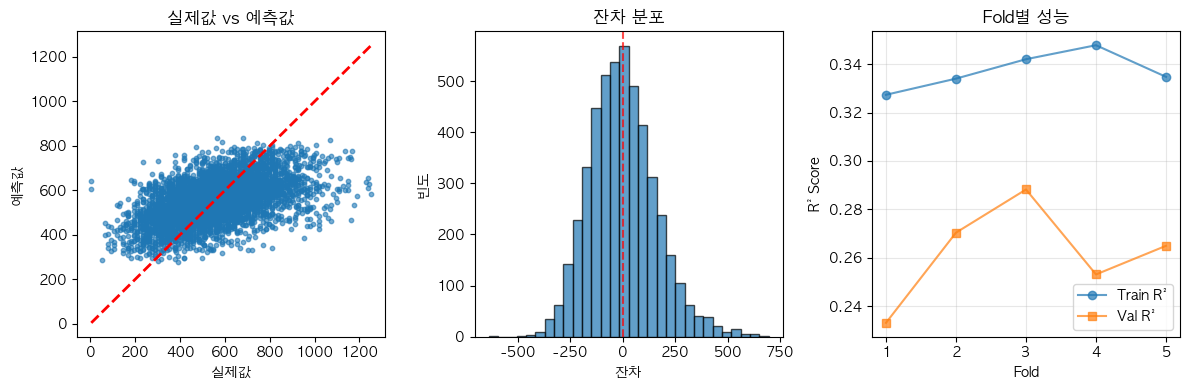


=== Fold별 성능 요약 ===
   fold  train_rmse  val_rmse  train_r2  val_r2  best_iteration
0     1     154.049   161.433     0.327   0.233              25
1     2     152.139   162.221     0.334   0.270              32
2     3     151.893   157.425     0.342   0.288              41
3     4     150.525   164.268     0.348   0.253              40
4     5     153.179   158.170     0.335   0.265              31


In [16]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# 한글 폰트 설정 (맥 환경)
import matplotlib.font_manager as fm

plt.rcParams["font.family"] = "AppleGothic"  # 맥용 한글 폰트
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 2. Outcome function (features로 y 예측)
print("=== Outcome Function 학습 (features → y) ===")

X_features = df[features]
y_outcome = df[y[0]]  # y는 리스트이므로 첫 번째 요소 추출

print(f"Features: {features}")
print(f"Target: {y[0]}")
print(f"데이터 크기: X={X_features.shape}, y={y_outcome.shape}")
print(f"Target 통계:")
print(f"  평균: {y_outcome.mean():.2f}")
print(f"  표준편차: {y_outcome.std():.2f}")
print(f"  범위: [{y_outcome.min():.2f}, {y_outcome.max():.2f}]")

# Out-of-sample 예측값 저장용 배열
outcome_predictions = np.zeros(len(df))

# KFold로 분할 (회귀 문제이므로 StratifiedKFold 대신 KFold 사용)
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
fold_performances = []

# LightGBM 파라미터 설정 (과적합 방지에 중점)
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "num_leaves": 15,  # 작게 설정하여 과적합 방지
    "learning_rate": 0.1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.1,  # L1 정규화
    "lambda_l2": 0.1,  # L2 정규화
    "min_data_in_leaf": 20,
    "min_split_gain": 0.1,
    "max_depth": 6,
    "verbose": -1,
    "random_state": RANDOM_SEED,
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_features, y_outcome)):
    print(f"\n=== Fold {fold + 1} ===")

    X_train, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
    y_train, y_val = y_outcome.iloc[train_idx], y_outcome.iloc[val_idx]

    print(f"Train 크기: {len(X_train)}, Val 크기: {len(X_val)}")
    print(f"Train target 평균: {y_train.mean():.2f}, Val target 평균: {y_val.mean():.2f}")

    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # 모델 훈련
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=["train", "eval"],
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0),  # 로그 출력 비활성화
        ],
    )

    # 예측
    train_pred = model.predict(X_train, num_iteration=model.best_iteration)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # Out-of-sample 예측값 저장
    outcome_predictions[val_idx] = val_pred

    # 성능 계산
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    val_mae = mean_absolute_error(y_val, val_pred)

    fold_performances.append(
        {
            "fold": fold + 1,
            "train_rmse": train_rmse,
            "val_rmse": val_rmse,
            "train_r2": train_r2,
            "val_r2": val_r2,
            "train_mae": train_mae,
            "val_mae": val_mae,
            "best_iteration": model.best_iteration,
            "train_size": len(X_train),
            "val_size": len(X_val),
        }
    )

    print(f"훈련 RMSE: {train_rmse:.3f}, 검증 RMSE: {val_rmse:.3f}")
    print(f"훈련 R²: {train_r2:.3f}, 검증 R²: {val_r2:.3f}")
    print(f"훈련 MAE: {train_mae:.3f}, 검증 MAE: {val_mae:.3f}")
    print(f"최적 반복횟수: {model.best_iteration}")

# 원본 df에 outcome 예측값 추가
df["outcome_prediction"] = outcome_predictions

print(f"\n=== 전체 Outcome Function 결과 ===")
performance_df = pd.DataFrame(fold_performances)

print(f"평균 훈련 RMSE: {performance_df['train_rmse'].mean():.3f} ± {performance_df['train_rmse'].std():.3f}")
print(f"평균 검증 RMSE: {performance_df['val_rmse'].mean():.3f} ± {performance_df['val_rmse'].std():.3f}")
print(f"평균 훈련 R²: {performance_df['train_r2'].mean():.3f} ± {performance_df['train_r2'].std():.3f}")
print(f"평균 검증 R²: {performance_df['val_r2'].mean():.3f} ± {performance_df['val_r2'].std():.3f}")
print(f"평균 훈련 MAE: {performance_df['train_mae'].mean():.3f} ± {performance_df['train_mae'].std():.3f}")
print(f"평균 검증 MAE: {performance_df['val_mae'].mean():.3f} ± {performance_df['val_mae'].std():.3f}")

# 과적합 체크
overfitting_score = performance_df["train_r2"].mean() - performance_df["val_r2"].mean()
print(f"\n과적합 지표 (Train R² - Val R²): {overfitting_score:.3f}")
if overfitting_score > 0.1:
    print("⚠️  심각한 과적합이 감지되었습니다. 정규화를 강화하세요.")
elif overfitting_score > 0.05:
    print("⚠️  약간의 과적합이 있습니다.")
else:
    print("✅ 과적합이 잘 제어되고 있습니다.")

print(f"\n처음 10개 샘플의 실제값 vs 예측값:")
comparison_df = df[[y[0], "outcome_prediction"]].head(10)
comparison_df["residual"] = comparison_df[y[0]] - comparison_df["outcome_prediction"]
print(comparison_df)

print(f"\nOutcome 예측값 통계:")
print(f"  평균: {df['outcome_prediction'].mean():.2f}")
print(f"  표준편차: {df['outcome_prediction'].std():.2f}")
print(f"  범위: [{df['outcome_prediction'].min():.2f}, {df['outcome_prediction'].max():.2f}]")

# 잔차 계산 (R-learner의 다음 단계를 위해)
df["outcome_residual"] = df[y[0]] - df["outcome_prediction"]
print(f"\nOutcome 잔차 통계:")
print(f"  평균: {df['outcome_residual'].mean():.2f} (0에 가까워야 함)")
print(f"  표준편차: {df['outcome_residual'].std():.2f}")

# 시각화
plt.figure(figsize=(12, 4))

# 1. 실제값 vs 예측값
plt.subplot(1, 3, 1)
plt.scatter(df[y[0]], df["outcome_prediction"], alpha=0.6, s=10)
plt.plot([df[y[0]].min(), df[y[0]].max()], [df[y[0]].min(), df[y[0]].max()], "r--", lw=2)
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title("실제값 vs 예측값")

# 2. 잔차 분포
plt.subplot(1, 3, 2)
plt.hist(df["outcome_residual"], bins=30, alpha=0.7, edgecolor="black")
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title("잔차 분포")
plt.axvline(0, color="red", linestyle="--", alpha=0.7)

# 3. Fold별 성능
plt.subplot(1, 3, 3)
plt.plot(performance_df["fold"], performance_df["train_r2"], "o-", label="Train R²", alpha=0.7)
plt.plot(performance_df["fold"], performance_df["val_r2"], "s-", label="Val R²", alpha=0.7)
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.title("Fold별 성능")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 성능 요약 테이블
print(f"\n=== Fold별 성능 요약 ===")
print(performance_df[["fold", "train_rmse", "val_rmse", "train_r2", "val_r2", "best_iteration"]].round(3))

In [22]:
df.iloc[[4799, 4800]]

,Cas_ata,Cas_acd_endo,Cas_clr,age,size,meas_vault,outcome_prediction,outcome_residual
4799,11.55,3.28,73.0,35,12.1,496.0,427.841553,68.158447
4800,11.69,3.44,-201.0,25,12.1,496.0,620.337738,-124.337738


/var/folders/ph/943dsflx24lbsx8rz54h45rw0000gn/T/ipykernel_74913/385186065.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(size_groups, labels=size_labels)


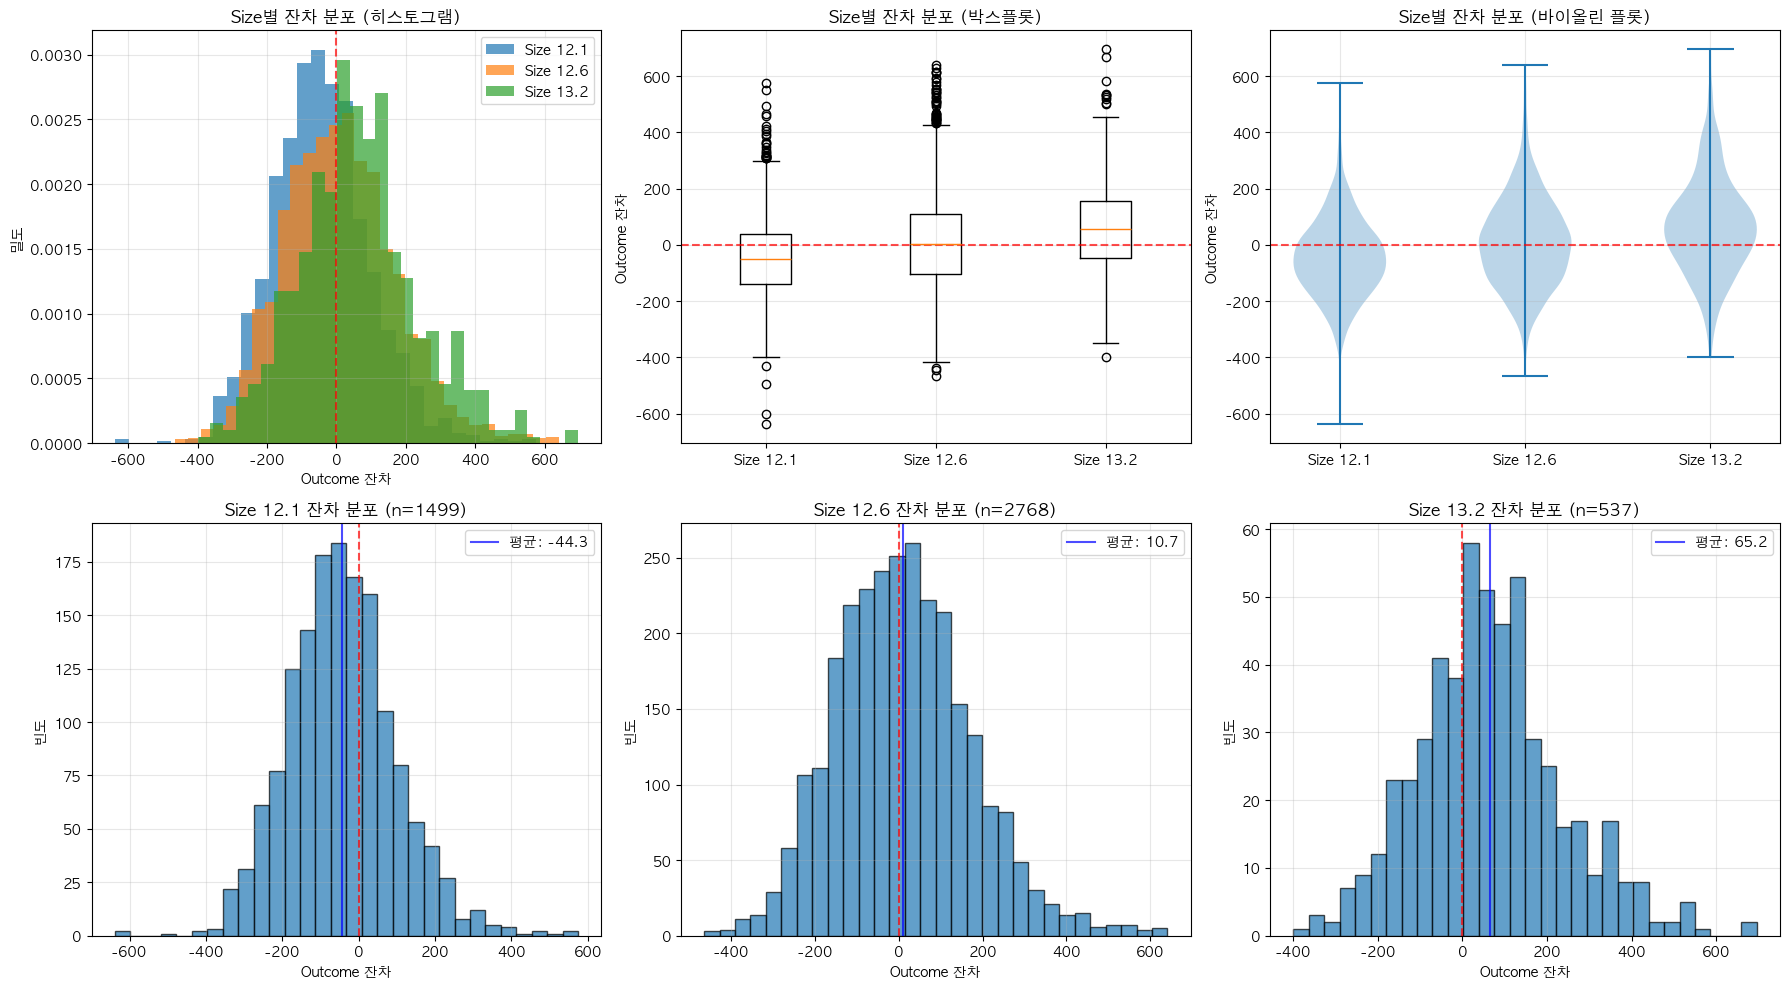

=== Size별 잔차 통계 ===

Size 12.1 (n=1499):
  평균:       -44.32
  표준편차:   141.50
  중앙값:     -50.96
  범위:     [-638.9,  574.6]

Size 12.6 (n=2768):
  평균:        10.69
  표준편차:   161.96
  중앙값:       3.74
  범위:     [-464.8,  641.3]

Size 13.2 (n=537):
  평균:        65.24
  표준편차:   172.67
  중앙값:      58.07
  범위:     [-399.6,  696.1]

전체 (n=4804):
  평균:        -0.38
  표준편차:   160.74

=== ANOVA 검정 (size별 잔차 평균 차이) ===
F-통계량: 112.2751
p-value:  0.000000
❌ Size별로 잔차 평균에 유의한 차이가 있음 (문제)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

# Size별 잔차 분포 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Size별 히스토그램 (겹치게)
plt.subplot(2, 3, 1)
for size in sorted(df["size"].unique()):
    residuals = df[df["size"] == size]["outcome_residual"]
    plt.hist(residuals, bins=30, alpha=0.7, label=f"Size {size}", density=True)

plt.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Outcome 잔차")
plt.ylabel("밀도")
plt.title("Size별 잔차 분포 (히스토그램)")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Size별 박스플롯
plt.subplot(2, 3, 2)
size_groups = [df[df["size"] == size]["outcome_residual"] for size in sorted(df["size"].unique())]
size_labels = [f"Size {size}" for size in sorted(df["size"].unique())]

plt.boxplot(size_groups, labels=size_labels)
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.ylabel("Outcome 잔차")
plt.title("Size별 잔차 분포 (박스플롯)")
plt.grid(True, alpha=0.3)

# 3. 바이올린 플롯
plt.subplot(2, 3, 3)
parts = plt.violinplot(size_groups, positions=range(1, len(size_groups) + 1))
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.xticks(range(1, len(size_labels) + 1), size_labels)
plt.ylabel("Outcome 잔차")
plt.title("Size별 잔차 분포 (바이올린 플롯)")
plt.grid(True, alpha=0.3)

# 4-6. Size별 개별 히스토그램
for i, size in enumerate(sorted(df["size"].unique())):
    plt.subplot(2, 3, 4 + i)
    residuals = df[df["size"] == size]["outcome_residual"]

    plt.hist(residuals, bins=30, alpha=0.7, edgecolor="black")
    plt.axvline(0, color="red", linestyle="--", alpha=0.7)
    plt.axvline(residuals.mean(), color="blue", linestyle="-", alpha=0.7, label=f"평균: {residuals.mean():.1f}")

    plt.xlabel("Outcome 잔차")
    plt.ylabel("빈도")
    plt.title(f"Size {size} 잔차 분포 (n={len(residuals)})")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Size별 통계 요약
print("=== Size별 잔차 통계 ===")
for size in sorted(df["size"].unique()):
    residuals = df[df["size"] == size]["outcome_residual"]
    print(f"\nSize {size} (n={len(residuals)}):")
    print(f"  평균:     {residuals.mean():8.2f}")
    print(f"  표준편차: {residuals.std():8.2f}")
    print(f"  중앙값:   {residuals.median():8.2f}")
    print(f"  범위:     [{residuals.min():6.1f}, {residuals.max():6.1f}]")

# 전체 잔차 통계
print(f"\n전체 (n={len(df)}):")
print(f"  평균:     {df['outcome_residual'].mean():8.2f}")
print(f"  표준편차: {df['outcome_residual'].std():8.2f}")

# ANOVA 검정 (size별 잔차 평균 차이 검정)
from scipy.stats import f_oneway

size_12_1 = df[df["size"] == 12.1]["outcome_residual"]
size_12_6 = df[df["size"] == 12.6]["outcome_residual"]
size_13_2 = df[df["size"] == 13.2]["outcome_residual"]

f_stat, p_value = f_oneway(size_12_1, size_12_6, size_13_2)
print(f"\n=== ANOVA 검정 (size별 잔차 평균 차이) ===")
print(f"F-통계량: {f_stat:.4f}")
print(f"p-value:  {p_value:.6f}")

if p_value < 0.05:
    print("❌ Size별로 잔차 평균에 유의한 차이가 있음 (문제)")
else:
    print("✅ Size별 잔차 평균에 유의한 차이 없음 (좋음)")

> 잔차화가 잘 됐는지는 어떻게 판단할 수 있는거지?   

주요 평가 기준:

1. 조건부 독립성 (가장 중요)
- E[잔차|X] ≈ 0
- R² < 0.01 이면 우수
- R² > 0.05 이면 문제

2. 편향 제거
- 잔차 평균 ≈ 0
- 체계적인 과대/과소예측 없음

3. 정규성
- 잔차가 정규분포 형태
- 왜도, 첨도가 0에 가까움

4. 잔차 간 독립성
- Treatment 잔차와 Outcome 잔차 간 낮은 상관관계
- 상관계수 < 0.1 이면 이상적

조건부 독립성 검사: E[outcome_residual | X] = 0

1. 전체 조건부 독립성 검사
----------------------------------------
Features로 잔차 예측 R²: 0.001075
✅ 우수: 강한 조건부 독립성

2. 각 Feature별 상관관계
----------------------------------------
Cas_ata        :   0.0142 ✅ 매우 낮음
Cas_acd_endo   :   0.0255 ✅ 매우 낮음
Cas_clr        :  -0.0251 ✅ 매우 낮음
age            :  -0.0187 ✅ 매우 낮음

3. 잔차 기본 통계
----------------------------------------
평균:      -0.3763 (0에 가까워야 함)
표준편차: 160.7405
왜도:       0.4576 (0에 가까워야 함)
첨도:       0.6808 (0에 가까워야 함)

4. 통계적 검정
----------------------------------------
F-검정 (전체 모델 유의성):
  F-통계량: 1.2907
  p-value:  0.271168
  ✅ 잔차와 features 간 유의한 관계 없음 (좋음)

Shapiro-Wilk 정규성 검정:
  통계량:   0.9879
  p-value:  0.000000
  ⚠️  잔차가 정규분포를 벗어남

5. 시각적 진단
----------------------------------------


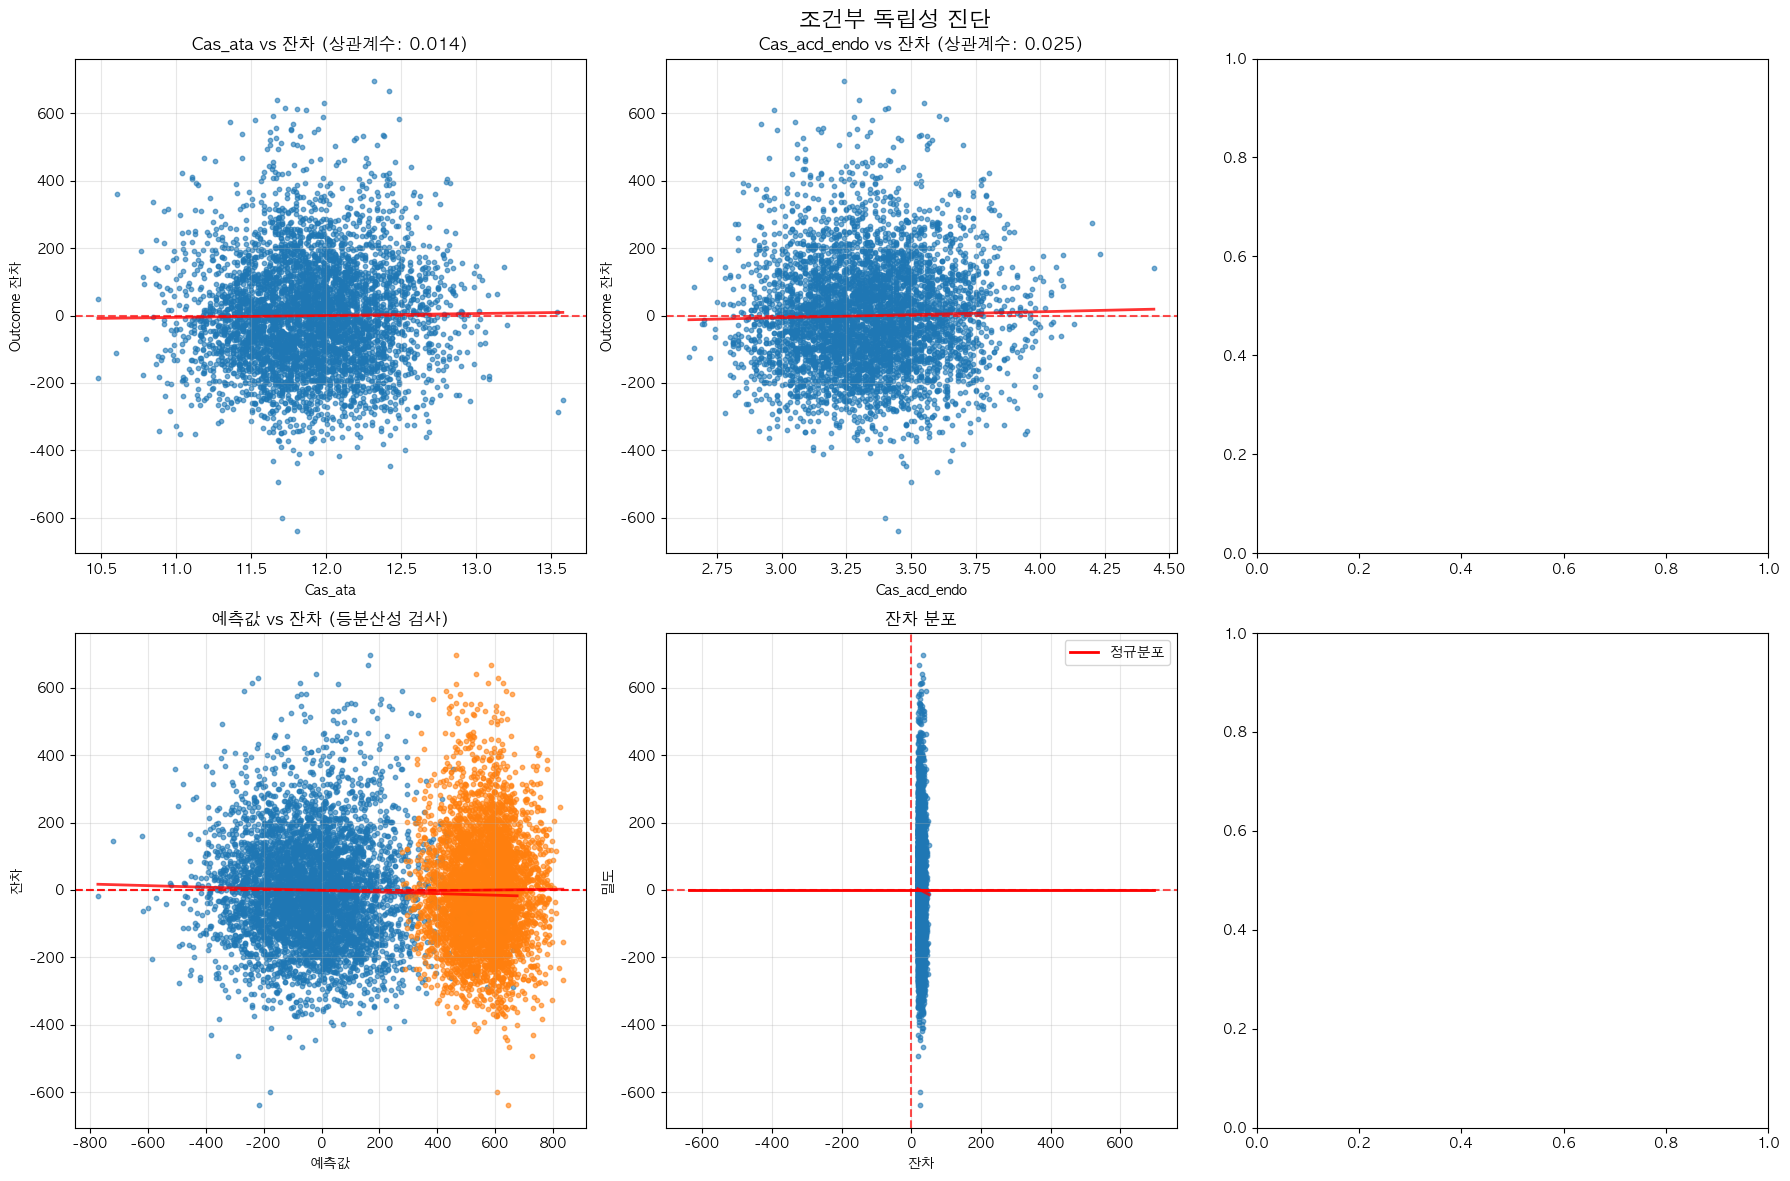

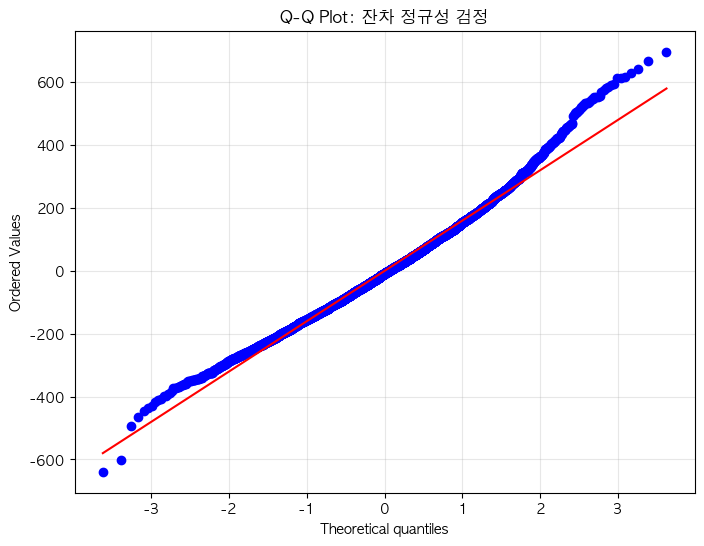


종합 평가
조건부 독립성 등급: A
전체 R²: 0.001075
발견된 문제: 1개

문제점:
  ❌ 편향 존재

개선 방안:
  🔧 모델 복잡도 증가 (더 많은 features, interaction terms)
  🔧 비선형 변환 적용
  🔧 정규화 파라미터 조정
  🔧 다른 알고리즘 시도 (XGBoost, Neural Network)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

# 한글 폰트 설정
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False


def check_conditional_independence_comprehensive(df):
    """
    Outcome 잔차의 조건부 독립성을 종합적으로 확인
    """

    features = ["Cas_ata", "Cas_acd_endo", "Cas_clr", "age"]
    residual_col = "outcome_residual"

    print("=" * 60)
    print("조건부 독립성 검사: E[outcome_residual | X] = 0")
    print("=" * 60)

    X = df[features]
    residuals = df[residual_col]

    # ===== 1. 전체 R² 확인 =====
    print("\n1. 전체 조건부 독립성 검사")
    print("-" * 40)

    model = LinearRegression()
    model.fit(X, residuals)
    predictions = model.predict(X)
    r2_total = r2_score(residuals, predictions)

    print(f"Features로 잔차 예측 R²: {r2_total:.6f}")

    # R² 평가
    if r2_total < 0.001:
        print("🎉 우수: 매우 강한 조건부 독립성")
        grade = "A+"
    elif r2_total < 0.01:
        print("✅ 우수: 강한 조건부 독립성")
        grade = "A"
    elif r2_total < 0.05:
        print("⚠️  양호: 약간의 의존성 존재")
        grade = "B"
    elif r2_total < 0.1:
        print("⚠️  보통: 중간 정도의 의존성")
        grade = "C"
    else:
        print("❌ 문제: 강한 의존성 - 모델 개선 필요")
        grade = "D"

    # ===== 2. 각 feature별 상관관계 =====
    print(f"\n2. 각 Feature별 상관관계")
    print("-" * 40)

    correlations = {}
    for feature in features:
        corr = np.corrcoef(df[feature], residuals)[0, 1]
        correlations[feature] = corr

        if abs(corr) < 0.05:
            status = "✅ 매우 낮음"
        elif abs(corr) < 0.1:
            status = "⚠️  낮음"
        elif abs(corr) < 0.2:
            status = "⚠️  중간"
        else:
            status = "❌ 높음"

        print(f"{feature:15}: {corr:8.4f} {status}")

    # ===== 3. 잔차의 기본 통계 =====
    print(f"\n3. 잔차 기본 통계")
    print("-" * 40)

    mean_residual = residuals.mean()
    std_residual = residuals.std()
    skew_residual = stats.skew(residuals)
    kurt_residual = stats.kurtosis(residuals)

    print(f"평균:     {mean_residual:8.4f} (0에 가까워야 함)")
    print(f"표준편차: {std_residual:8.4f}")
    print(f"왜도:     {skew_residual:8.4f} (0에 가까워야 함)")
    print(f"첨도:     {kurt_residual:8.4f} (0에 가까워야 함)")

    # ===== 4. 통계적 검정 =====
    print(f"\n4. 통계적 검정")
    print("-" * 40)

    # F-test for overall significance
    n = len(residuals)
    k = len(features)
    f_stat = (r2_total / k) / ((1 - r2_total) / (n - k - 1))
    f_p_value = 1 - stats.f.cdf(f_stat, k, n - k - 1)

    print(f"F-검정 (전체 모델 유의성):")
    print(f"  F-통계량: {f_stat:.4f}")
    print(f"  p-value:  {f_p_value:.6f}")

    if f_p_value > 0.05:
        print("  ✅ 잔차와 features 간 유의한 관계 없음 (좋음)")
    else:
        print("  ❌ 잔차와 features 간 유의한 관계 존재 (문제)")

    # Shapiro-Wilk test for normality (샘플이 너무 크면 생략)
    if len(residuals) <= 5000:
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        print(f"\nShapiro-Wilk 정규성 검정:")
        print(f"  통계량:   {shapiro_stat:.4f}")
        print(f"  p-value:  {shapiro_p:.6f}")

        if shapiro_p > 0.05:
            print("  ✅ 잔차가 정규분포를 따름")
        else:
            print("  ⚠️  잔차가 정규분포를 벗어남")

    # ===== 5. 시각화 =====
    print(f"\n5. 시각적 진단")
    print("-" * 40)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle("조건부 독립성 진단", fontsize=16)

    # 5-1. 각 feature vs 잔차
    for i, feature in enumerate(features):
        row = i // 2
        col = i % 2

        axes[row, col].scatter(df[feature], residuals, alpha=0.6, s=10)
        axes[row, col].axhline(0, color="red", linestyle="--", alpha=0.7)

        # 추세선
        z = np.polyfit(df[feature], residuals, 1)
        p = np.poly1d(z)
        x_line = np.linspace(df[feature].min(), df[feature].max(), 100)
        axes[row, col].plot(x_line, p(x_line), "r-", alpha=0.8, linewidth=2)

        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel("Outcome 잔차")
        axes[row, col].set_title(f"{feature} vs 잔차 (상관계수: {correlations[feature]:.3f})")
        axes[row, col].grid(True, alpha=0.3)

    # 5-2. 예측값 vs 잔차
    axes[1, 0].scatter(df["outcome_prediction"], residuals, alpha=0.6, s=10)
    axes[1, 0].axhline(0, color="red", linestyle="--", alpha=0.7)

    z = np.polyfit(df["outcome_prediction"], residuals, 1)
    p = np.poly1d(z)
    x_line = np.linspace(df["outcome_prediction"].min(), df["outcome_prediction"].max(), 100)
    axes[1, 0].plot(x_line, p(x_line), "r-", alpha=0.8, linewidth=2)

    axes[1, 0].set_xlabel("예측값")
    axes[1, 0].set_ylabel("잔차")
    axes[1, 0].set_title("예측값 vs 잔차 (등분산성 검사)")
    axes[1, 0].grid(True, alpha=0.3)

    # 5-3. 잔차 분포
    axes[1, 1].hist(residuals, bins=50, density=True, alpha=0.7, edgecolor="black")

    # 정규분포 곡선 오버레이
    mu, sigma = residuals.mean(), residuals.std()
    x_norm = np.linspace(residuals.min(), residuals.max(), 100)
    axes[1, 1].plot(x_norm, stats.norm.pdf(x_norm, mu, sigma), "r-", lw=2, label="정규분포")
    axes[1, 1].axvline(0, color="red", linestyle="--", alpha=0.7)

    axes[1, 1].set_xlabel("잔차")
    axes[1, 1].set_ylabel("밀도")
    axes[1, 1].set_title("잔차 분포")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ===== 6. Q-Q Plot =====
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot: 잔차 정규성 검정")
    plt.grid(True, alpha=0.3)
    plt.show()

    # ===== 7. 종합 평가 =====
    print(f"\n" + "=" * 60)
    print("종합 평가")
    print("=" * 60)

    issues = []

    if r2_total > 0.05:
        issues.append("조건부 독립성 위반")

    if abs(mean_residual) > 0.1:
        issues.append("편향 존재")

    if any(abs(corr) > 0.2 for corr in correlations.values()):
        issues.append("강한 feature 의존성")

    if f_p_value < 0.05:
        issues.append("통계적으로 유의한 의존성")

    print(f"조건부 독립성 등급: {grade}")
    print(f"전체 R²: {r2_total:.6f}")
    print(f"발견된 문제: {len(issues)}개")

    if issues:
        print("\n문제점:")
        for issue in issues:
            print(f"  ❌ {issue}")

        print(f"\n개선 방안:")
        print(f"  🔧 모델 복잡도 증가 (더 많은 features, interaction terms)")
        print(f"  🔧 비선형 변환 적용")
        print(f"  🔧 정규화 파라미터 조정")
        print(f"  🔧 다른 알고리즘 시도 (XGBoost, Neural Network)")
    else:
        print("\n🎉 조건부 독립성이 잘 만족됩니다!")
        print("✅ R-learner의 다음 단계로 진행 가능")

    return {
        "r2_total": r2_total,
        "correlations": correlations,
        "mean_residual": mean_residual,
        "f_p_value": f_p_value,
        "grade": grade,
        "issues": issues,
    }


# 실행
results = check_conditional_independence_comprehensive(df)

# 3. CATE 추정 모델
> CATE(X, T)

In [ ]:
class MultiTreatmentRLearner:
    def __init__(self, model_y, model_t, model_final):
        self.model_y = model_y  # Y 모델
        self.model_t = model_t  # Treatment propensity 모델
        self.model_final = model_final  # Final stage 모델

    def fit(self, Y, T, X, W=None):
        # Step 1: Estimate E[Y|X,W]
        if W is not None:
            XW = np.concatenate([X, W], axis=1)
        else:
            XW = X

        self.model_y.fit(XW, Y)
        Y_pred = self.model_y.predict(XW)
        Y_res = Y - Y_pred  # Y residuals

        # Step 2: Multi-treatment propensity estimation
        # One-hot encode treatments
        T_onehot = pd.get_dummies(T, drop_first=True)
        T_pred = np.zeros_like(T_onehot)

        for k, col in enumerate(T_onehot.columns):
            # Each treatment vs rest
            self.model_t.fit(XW, T_onehot[col])
            T_pred[:, k] = self.model_t.predict_proba(XW)[:, 1]

        T_res = T_onehot - T_pred  # Treatment residuals

        # Step 3: Final stage - regress Y_res on T_res * X
        # Create interaction terms
        features = []
        for k in range(T_res.shape[1]):
            # θ_k(X) = X * α_k (linear case)
            interaction = T_res[:, k : k + 1] * X
            features.append(interaction)

        final_features = np.concatenate(features, axis=1)
        self.model_final.fit(final_features, Y_res)

    def predict(self, X, T0, T1):
        # Predict treatment effects between T0 and T1
        # θ(X) * (T1 - T0)
        pass

In [ ]:
from econml.dml import DML
from econml.metalearners import XLearner, TLearner

# EconML의 meta-learners는 multi-treatment 지원
xl = XLearner(models=RandomForestRegressor())
xl.fit(Y, T, X=X)  # T can be multi-valued

In [ ]:
from causalml.inference.meta import XLearner
# Multi-treatment support